# This notebook works on extracting unique named entities and organizations from KDD papers and passing them into a list.  

In [83]:
import pandas as pd
import numpy as np
import nltk
import os
import subprocess
import unicodedata
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from nltk import Tree
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
import re
from operator import itemgetter

In [263]:
path        = os.path.abspath(os.getcwd())
TESTDIR     = os.path.normpath(os.path.join(os.path.expanduser("~"),"projects","LC3-Creations", "examples","KDDsample"))


In [267]:
a = unicode(subprocess.check_output(['pdf2txt.py',str(os.path.normpath(os.path.join(TESTDIR,"p39.pdf")))]),errors='ignore')
document = unicodedata.normalize('NFKD', a).encode('ascii','ignore')


In [299]:
"returns named entity chunks in a given text"
tagged = nltk.pos_tag(nltk.word_tokenize(re.sub('[\s]'," ", document[:2000])))
entities = nltk.chunk.ne_chunk(tagged)
# Another entity extractor
st = StanfordNERTagger('/Users/linwood/stanford-corenlp-full-2015-04-20/classifiers/english.conll.4class.distsim.crf.ser.gz',
       '/Users/linwood/stanford-corenlp-full-2015-04-20/stanford-corenlp-3.5.2.jar',
       encoding='utf-8')
tokenized_text = word_tokenize(re.sub('[\s]'," ", document[:2000]))
stanentities = st.tag(tokenized_text)

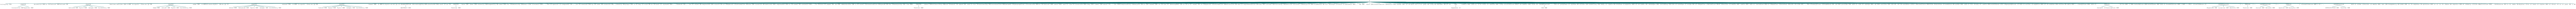

In [300]:
entities   

Below, I established two lists to hold the values that I extract from the text.  This itemgetter function will check for unique values.  First, I iterate over the extracted entities and see if the objects is a nltk.tree.Tree with a "Person" label.  If it is, and the length is equal to 1 (first or last name only), I append that value to the list. If it's larger, I iterate of the entity tree and pull out the first value only using itemgetter.  Then, I join the values from the list and append it to the destination list.  

In [312]:
from operator import itemgetter

persons = []
organizations = []

for l in entities:
    if isinstance(l,nltk.tree.Tree):
        if l.label() == 'PERSON':
            if len(l)== 1:
                if l[0][0] in persons:
                    pass
                else:
                    persons.append(l[0][0])
            else:
                if " ".join(map(itemgetter(0), o)) in persons:
                    pass
                else:
                    persons.append(" ".join(map(itemgetter(0), l)))
                    
for o in entities:
    if isinstance(o,nltk.tree.Tree):
        if o.label() == 'ORGANIZATION' or o.label() == 'GPE':
            if len(o)== 1:
                if o[0][0] in organizations:
                    pass
                else:
                    organizations.append(o[0][0])
            else:
                if " ".join(map(itemgetter(0), o)) in organizations:
                    pass
                else:
                    organizations.append(" ".join(map(itemgetter(0), o)))
                    
                
print persons
print
print
print organizations

['Collective Spatial', 'Antoine Kyoto Sangyo University', 'Adam Jatowt Kyoto University', 'Shoko Wakamiya Kyoto Sangyo University', 'Yukiko Kawai Kyoto Sangyo University', 'Twitter', 'Subject Descriptors', 'Spatial Analysis']


['ABSTRACT', 'Japanese', 'USA', 'Keywords Location Mention', 'Social Network', 'INTRODUCTION Twitter']


In [302]:
from operator import itemgetter

for o in entities:
    if isinstance(o,nltk.tree.Tree):
        if o.label() == 'ORGANIZATION' or o.label() == 'GPE':
            if len(o)>1:
                print " ".join(map(itemgetter(0), o))

Keywords Location Mention
Social Network
INTRODUCTION Twitter


I tried to iterate over the extracted list of entities to get a better break between person's and their university name.  

In [303]:
tokens = [nltk.word_tokenize(l) for l in persons]
fin = [nltk.chunk.ne_chunk(nltk.pos_tag(l)) for l in tokens]



In [306]:
new =[word_tokenize(l) for l in persons]
stan = [st.tag(l) for l in new]
stan

[[(u'Collective', u'O'), (u'Spatial', u'O')],
 [(u'Antoine', u'ORGANIZATION'),
  (u'Kyoto', u'ORGANIZATION'),
  (u'Sangyo', u'ORGANIZATION'),
  (u'University', u'ORGANIZATION')],
 [(u'Adam', u'ORGANIZATION'),
  (u'Jatowt', u'ORGANIZATION'),
  (u'Kyoto', u'ORGANIZATION'),
  (u'University', u'ORGANIZATION')],
 [(u'Shoko', u'ORGANIZATION'),
  (u'Wakamiya', u'ORGANIZATION'),
  (u'Kyoto', u'ORGANIZATION'),
  (u'Sangyo', u'ORGANIZATION'),
  (u'University', u'ORGANIZATION')],
 [(u'Yukiko', u'ORGANIZATION'),
  (u'Kawai', u'ORGANIZATION'),
  (u'Kyoto', u'ORGANIZATION'),
  (u'Sangyo', u'ORGANIZATION'),
  (u'University', u'ORGANIZATION')],
 [(u'Twitter', u'O')],
 [(u'Subject', u'O'), (u'Descriptors', u'O')],
 [(u'Spatial', u'ORGANIZATION'), (u'Analysis', u'ORGANIZATION')]]

This function looks though an extracted stanford ner list, and finds continuous entitiy labels.  This should create first name, last name records of entities.  

In [309]:
def get_continuous_chunks(tagged_sent):
    continuous_chunk = []
    current_chunk = []

    for token, tag in tagged_sent:
        if tag != "O":
            current_chunk.append((token, tag))
        else:
            if current_chunk: # if the current chunk is not empty
                continuous_chunk.append(current_chunk)
                current_chunk = []
    # Flush the final current_chunk into the continuous_chunk, if any.
    if current_chunk:
        continuous_chunk.append(current_chunk)
    return continuous_chunk

ne_tagged_sent = [('Rami', 'PERSON'), ('Eid', 'PERSON'), ('is', 'O'), ('studying', 'O'), ('at', 'O'), ('Stony', 'ORGANIZATION'), ('Brook', 'ORGANIZATION'), ('University', 'ORGANIZATION'), ('in', 'O'), ('NY', 'LOCATION')]

named_entities = get_continuous_chunks(ne_tagged_sent)
named_entities = get_continuous_chunks(ne_tagged_sent)
named_entities_str = [" ".join([token for token, tag in ne]) for ne in named_entities]
named_entities_str_tag = [(" ".join([token for token, tag in ne]), ne[0][1]) for ne in named_entities]


In [310]:
named_entities = get_continuous_chunks(stanentities)
named_entities_str = [" ".join([token for token, tag in ne]) for ne in named_entities]
named_entities_str

[u'Portraying Collective Spatial Attention',
 u'Twitter',
 u'Antoine Kyoto Sangyo University',
 u'Adam Jatowt Kyoto University',
 u'Shoko Wakamiya Kyoto Sangyo University',
 u'Yukiko Kawai Kyoto Sangyo University',
 u'Twitter',
 u'Twitter',
 u'Japanese',
 u'USA',
 u'Subject Descriptors H.5.m [ Information Interfaces',
 u'Keywords Location Mention']

In [170]:
list1 = range(10)

In [171]:
list2 = [i for i in xrange(7,17,1)]


In [172]:
set(list1) & set(list2)

{7, 8, 9}

In [232]:
def parts_of_speech(corpus):
    "returns named entity chunks in a given text"
    tagged = nltk.pos_tag(nltk.word_tokenize(corpus))
    entities = nltk.chunk.ne_chunk(tagged)
    # Another entity extractor
    st = StanfordNERTagger('/Users/linwood/stanford-corenlp-full-2015-04-20/classifiers/english.muc.7class.distsim.crf.ser.gz',
           '/Users/linwood/stanford-corenlp-full-2015-04-20/stanford-corenlp-3.5.2.jar',
           encoding='utf-8')
    tokenized_text = word_tokenize(corpus)
    stanentities = st.tag(tokenized_text)
    return entities
def find_entities(chunks):
    "given list of tagged parts of speech, returns unique named entities"

    def traverse(tree):
        "recursively traverses an nltk.tree.Tree to find named entities"
        entity_names = []
    
        if hasattr(tree, 'node') and tree.node:
            if tree.node == 'NE':
                entity_names.append(' '.join([child[0] for child in tree]))
            else:
                for child in tree:
                    entity_names.extend(traverse(child))
    
        return entity_names
    
    named_entities = []
    
    for chunk in chunks:
        entities = sorted(list(set([word for tree in chunk
                            for word in traverse(tree)])))
        for e in entities:
            if e not in named_entities:
                named_entities.append(e)
    return named_entities

In [313]:
import os
os.getcwd()

'/Users/linwood'